# %% [markdown]
# # COVID-19 Global Data Analysis
# 
# This notebook analyzes global COVID-19 trends including cases, deaths, and vaccination progress.

# %% [markdown]
# ## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import urllib.request
import os

# Configure plotting
%matplotlib inline
plt.style.use('ggplot')  # Changed from 'seaborn'
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# %%
# Download data if needed
data_url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
data_path = Path("data/raw/owid-covid-data.csv")

if not data_path.exists():
    os.makedirs(data_path.parent, exist_ok=True)
    print("Downloading dataset...")
    urllib.request.urlretrieve(data_url, data_path)
    print("Download complete!")
else:
    print("Data already exists")

Download complete!


In [3]:
# %%
# Load the dataset
df = pd.read_csv(data_path, parse_dates=['date'])
print(f"Data loaded with {len(df)} rows and {len(df.columns)} columns")

# Show basic info
df.info()

Data loaded with 429435 rows and 67 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    429435 non-null  object        
 1   continent                                   402910 non-null  object        
 2   location                                    429435 non-null  object        
 3   date                                        429435 non-null  datetime64[ns]
 4   total_cases                                 411804 non-null  float64       
 5   new_cases                                   410159 non-null  float64       
 6   new_cases_smoothed                          408929 non-null  float64       
 7   total_deaths                                411804 non-null  float64       
 8   new_deaths                    

%% [markdown]¶
## 2. Data Cleaning

In [4]:
# %%
# Select key columns and countries
key_columns = [
    'date', 'location', 'total_cases', 'new_cases',
    'total_deaths', 'new_deaths', 'total_vaccinations',
    'people_vaccinated', 'population'
]

countries = [
    'United States', 'India', 'Brazil', 
    'Germany', 'Kenya', 'United Kingdom'
]

# Filter data
df = df[key_columns]
df = df[df['location'].isin(countries)]

In [6]:
# %%
# Handle missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Forward fill within each country
df = df.groupby('location').apply(lambda x: x.ffill())

print("\nMissing values after cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
date                     0
location                 0
total_cases              8
new_cases              842
total_deaths             8
new_deaths             400
total_vaccinations    5504
people_vaccinated     5558
population               0
dtype: int64

Missing values after cleaning:
date                     0
location                 0
total_cases              0
new_cases                0
total_deaths             0
new_deaths               0
total_vaccinations    2249
people_vaccinated     2249
population               0
dtype: int64


C:\Users\PCMan\AppData\Local\Temp\ipykernel_8424\1996204457.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('location').apply(lambda x: x.ffill())


%% [markdown]¶
## 3. Exploratory Data Analysis

In [9]:
# Calculate additional metrics
df['death_rate'] = df['total_deaths'] / df['total_cases']
df['cases_per_million'] = (df['total_cases'] / df['population']) * 1e6

# Handle the index properly
if 'location' in df.index.names:
    # If location is in index AND columns, we need special handling
    df = df.reset_index(drop=True)  # This completely drops the index without adding columns

# Get latest data for each country
latest_data = df.groupby('location', as_index=False).last()  # More efficient than groupby+reset_index

In [10]:
# %%
# Show basic statistics
latest_data[['location', 'total_cases', 'total_deaths', 'death_rate']].sort_values('total_cases', ascending=False)

,location,total_cases,total_deaths,death_rate
5,United States,103436829.0,1193165.0,0.011535
2,India,45041748.0,533623.0,0.011847
1,Germany,38437756.0,174979.0,0.004552
0,Brazil,37511921.0,702116.0,0.018717
4,United Kingdom,24974629.0,232112.0,0.009294
3,Kenya,344106.0,5689.0,0.016533


%% [markdown]¶
## 4. Visualization

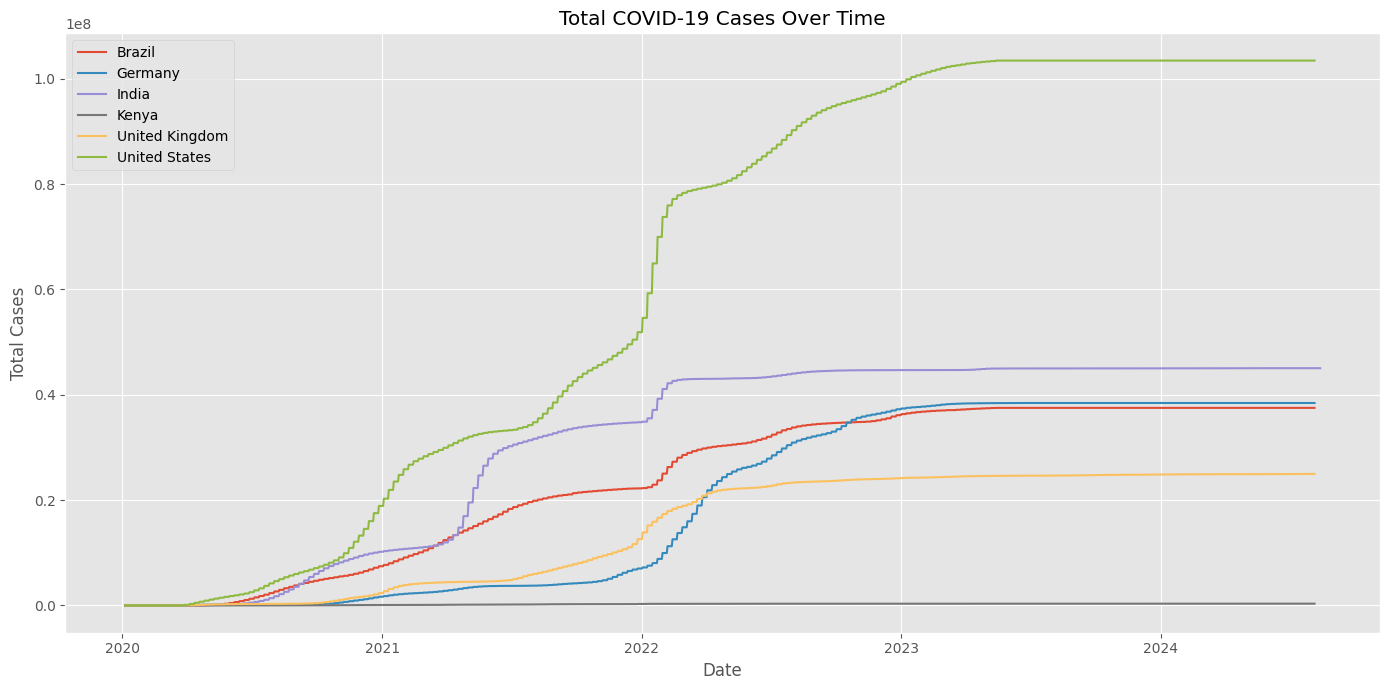

In [11]:
# %%
# Time series of total cases
plt.figure(figsize=(14, 7))
for country in df['location'].unique():
    country_data = df[df['location'] == country]
    plt.plot(country_data['date'], country_data['total_cases'], label=country)

plt.title('Total COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

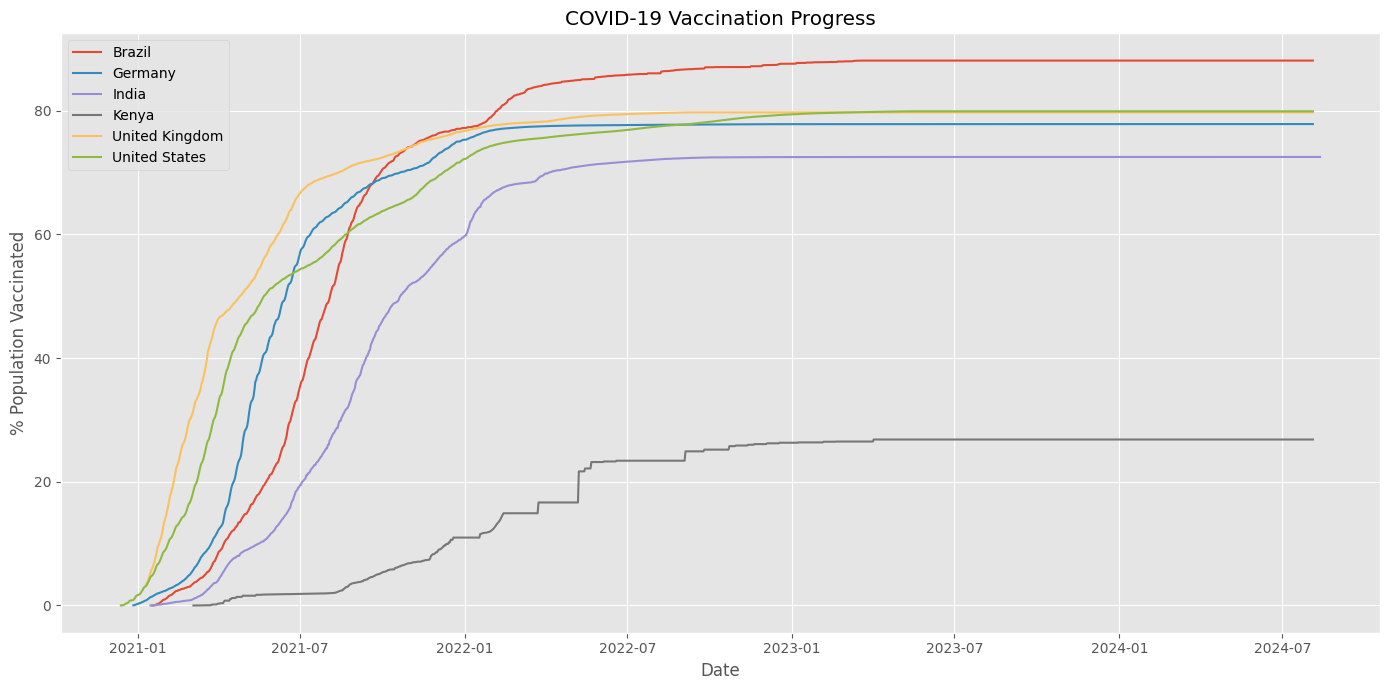

In [12]:
# %%
# Vaccination progress
plt.figure(figsize=(14, 7))
for country in df['location'].unique():
    country_data = df[df['location'] == country]
    vaccinated_pct = (country_data['people_vaccinated'] / 
                     country_data['population']) * 100
    plt.plot(country_data['date'], vaccinated_pct, label=country)

plt.title('COVID-19 Vaccination Progress')
plt.xlabel('Date')
plt.ylabel('% Population Vaccinated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

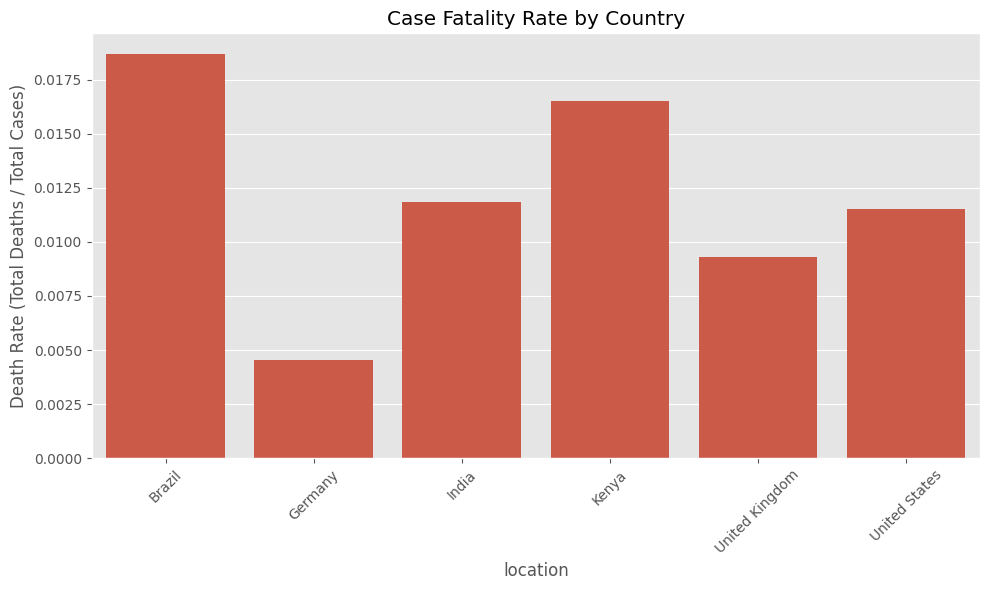

In [13]:
# %%
# Death rate comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='location', y='death_rate', data=latest_data)
plt.title('Case Fatality Rate by Country')
plt.ylabel('Death Rate (Total Deaths / Total Cases)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 5. Advanced Analysis

In [14]:
# %%
# Calculate 7-day moving averages
df['new_cases_7day_avg'] = df.groupby('location')['new_cases'].transform(
    lambda x: x.rolling(window=7).mean()
)

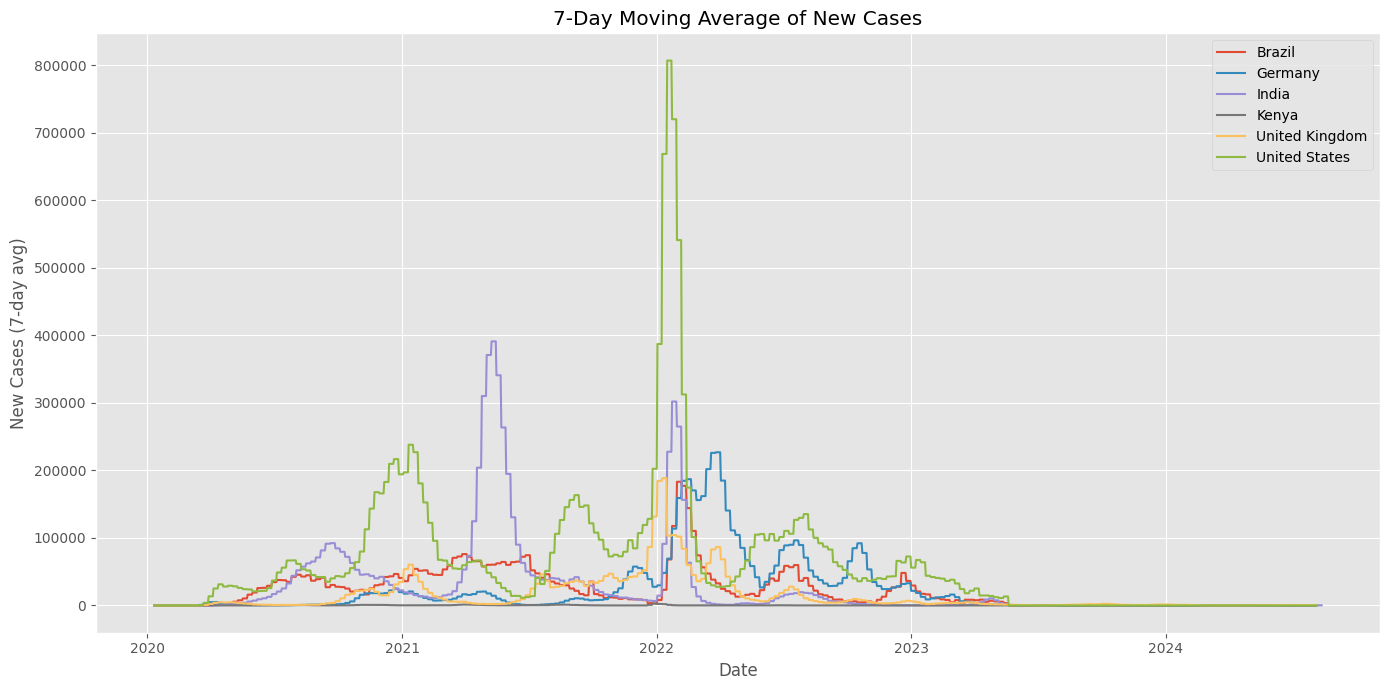

In [15]:
# %%
# Plot moving averages
plt.figure(figsize=(14, 7))
for country in df['location'].unique():
    country_data = df[df['location'] == country]
    plt.plot(country_data['date'], country_data['new_cases_7day_avg'], label=country)

plt.title('7-Day Moving Average of New Cases')
plt.xlabel('Date')
plt.ylabel('New Cases (7-day avg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 6. Insights and Conclusion

In [16]:
# %%
# Generate key insights
top_cases = latest_data.loc[latest_data['total_cases'].idxmax()]
top_vaccinations = latest_data.loc[latest_data['people_vaccinated'].idxmax()]
top_death_rate = latest_data.loc[latest_data['death_rate'].idxmax()]

print("Key Insights:")
print(f"- {top_cases['location']} has the highest total cases: {top_cases['total_cases']:,.0f}")
print(f"- {top_vaccinations['location']} has the most vaccinations: {top_vaccinations['people_vaccinated']:,.0f}")
print(f"- {top_death_rate['location']} has the highest death rate: {top_death_rate['death_rate']:.2%}")

Key Insights:
- United States has the highest total cases: 103,436,829
- India has the most vaccinations: 1,027,438,924
- Brazil has the highest death rate: 1.87%


In [17]:
# %%
# Save cleaned data and visualizations
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

# Save cleaned data
df.to_csv(output_dir / "cleaned_covid_data.csv", index=False)

# Save visualizations
figures_dir = output_dir / "figures"
figures_dir.mkdir(exist_ok=True)

plt.figure(figsize=(14, 7))
for country in df['location'].unique():
    country_data = df[df['location'] == country]
    plt.plot(country_data['date'], country_data['total_cases'], label=country)
plt.title('Total COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(figures_dir / "total_cases_trend.png", dpi=300, bbox_inches='tight')
plt.close()

print("Analysis results saved to 'output' directory")

Analysis results saved to 'output' directory
